![image](how.png)

**"Should I Stay or Should i Go (from the Hospital)"**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import prepare_df
from utils.files import rename_filename, file_exists

# Modelos de ML
# Import LabelEncoder
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Otros imports
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import pickle


In [3]:
# GLOBAL VARIABLES 

number_of_processors = -4  # -1 all, -2 all but one, ...
tsize=0.30
seed = 1

# baseline

In [4]:
#Cargar los datos
df = pd.read_csv("train_set.csv")

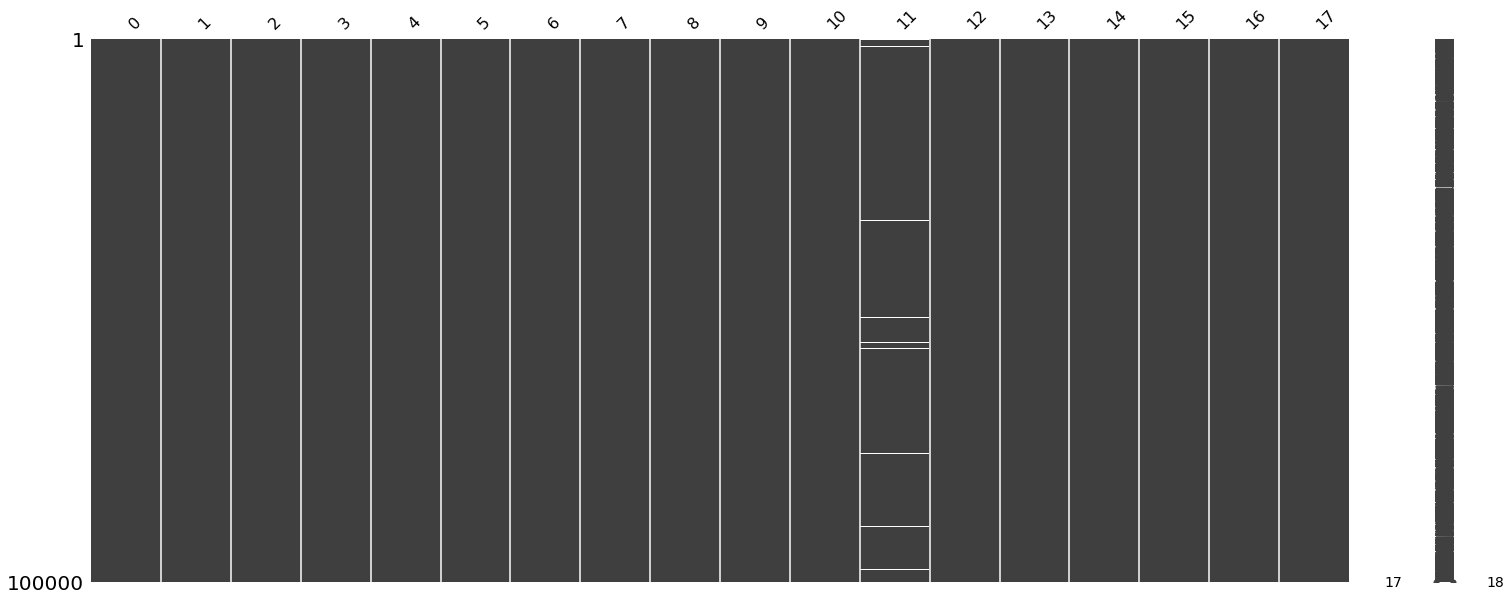

In [5]:
#Revisión gráfica de NANs
msno.matrix(df)

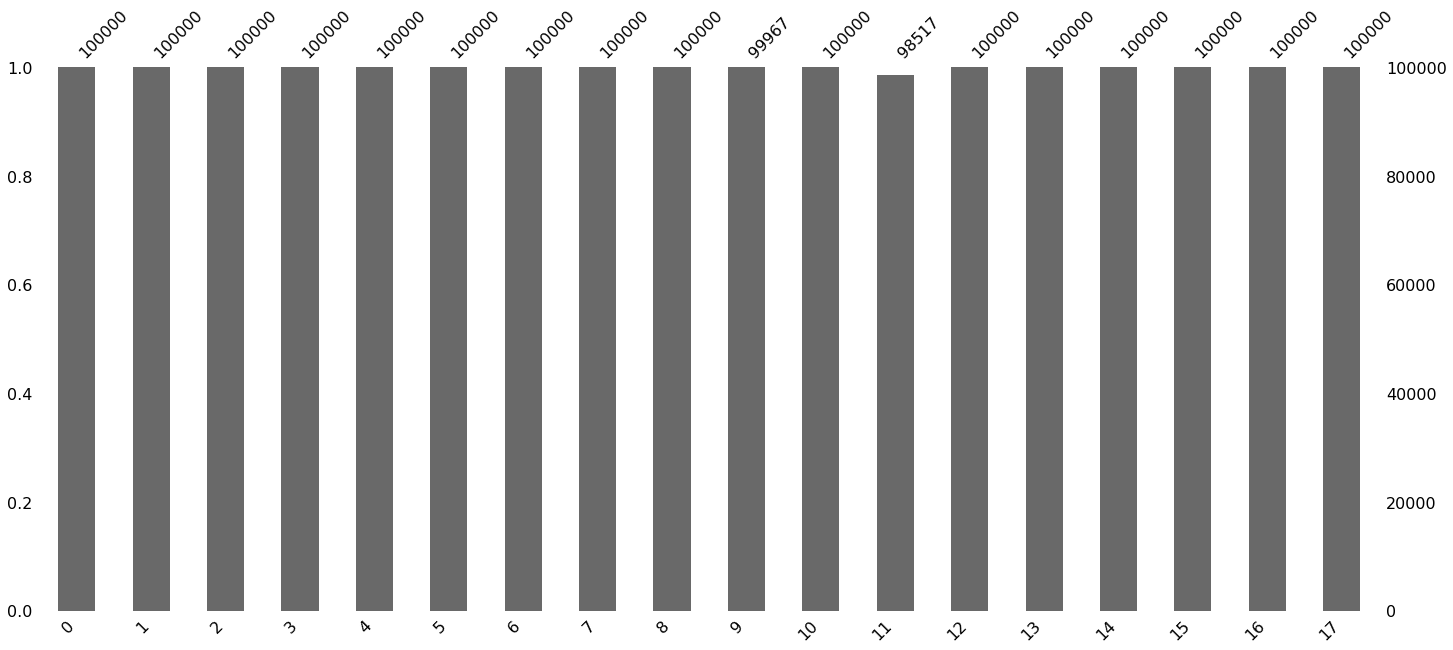

In [6]:
msno.bar(df)

In [7]:
# REVISAR LOS OUTLIERS
#plt.boxplot((df["11"]))

In [8]:
def limpiar_df(df, include_rows=False, elim_outl=False):
    """
    (1) (2) Columnas con NAN  
    (3) Tipos de columnas
    (4) Eliminar Outliers
    (5) Codificacion Label Encoder
    """
    df_mod=df.copy()
    # (1) Col 9 - Condition of Bed in the Ward   33 NAN  Como son pocos valores NAN los actalizaré con el valor 2.0 ( el mas frecuente) para no perderlos
    nan9=df_mod[df_mod["9"].isnull()].index.to_list()
    for elem in nan9:
        df_mod["9"].iloc[elem] = 2.0
            
    #(2) Col 11 - City Code for the patient   1483 NAN    Asignaré al City Code del paciente el City Code del hospital (según lo anterior) para los casos en que sea Nan`
    nan11=df_mod[df_mod["11"].isnull()].index.to_list()
    for elem in nan11:
        df_mod["11"].iloc[elem] = df_mod["3"].iloc[elem]

    #(3) Cambiar a object las columnas que deberían ser string y no tienen sentido que sean interpretadas como numero
    df_mod['1'] = df_mod['1'].astype('object')
    df_mod['3'] = df_mod['3'].astype('object')
    df_mod['11'] = df_mod['11'].astype('object')
    df_mod['9'] = df_mod['9'].astype('int64')

    if include_rows and elim_outl:
        #(4) Eliminar Outliers
        df_mod = df_mod[df_mod["14"]<=10]
        df_mod = df_mod[df_mod["5"]<9]

    return df_mod

In [9]:
#msno.bar(df)

Codificar los datos tipo string (usando Label Encoder)

In [10]:
X= limpiar_df(df=df,include_rows=True, elim_outl=True)

In [11]:
y = X[["17"]]

In [12]:
le_target= LabelEncoder()
le_target.fit(y["17"])
y["17"] = le_target.transform(y["17"]) 

In [13]:
X=prepare_df.transformar_df(df=X, aplic_encod=True,aplic_norm=False)

Ver correlación

In [14]:
#corr = X.corr()

In [15]:
#corr["17"].sort_values()

In [16]:
#plt.subplots(figsize=(10, 8)) 
#sns.heatmap(corr,  cmap= "BuPu", square=True,  annot=True)

No se comcluye nada. Solo pareciera una correlacion fuerte entre el target y la columna 14 (numero de visitantes)

#### 0. Seleccionar columnas a utilizar para el modelo

Eliminar columnas que no agregan informacion:  
0 :  pues corresponde al id del caso  
3 y 4 pues son redundantes con respecto al tipo  del hospital  
10: id del paciente pues son valores muy diversos   
17 ya extraida porque es el target  y no forma parte de las variables del modelo

In [17]:
cols_modelo = ["2", "5", "6","7", "8","9", "11", "12", "14","15","16"]
X = X.loc[:,cols_modelo]

#### 1. Definir X e y

In [18]:
X = X.values
y = y.values

#### 2. Dividir X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize, random_state=seed)

## Asignar modelo, Entrenarlo con X_train y y_train, Predecir con X_test, Sacar métricas, valorar el modelo 

# `Uno a uno`

### Logistic Regression

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(predictions)


[1 1 2 ... 2 2 2]


In [21]:
model.score(X_test,y_test) 

0.3460788270110304

In [22]:
# USANDO  VALIDACION CRUZADA
k_fold = RepeatedKFold(n_splits=25, n_repeats=4, random_state=1)
val_score = []
train_score = []
# define the model
model = LogisticRegression(warm_start=True)

for i, (train, val) in enumerate(k_fold.split(X_train)):
    # train the model
    model.fit(X_train[train], y_train[train])
    score_val = model.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model.score(X_train[train], y_train[train])
    train_score.append(score_train)
    print(np.mean(val_score))
    if np.mean(val_score) >= 0.40 and len(val_score) > 20:
        #pickle.dump(model, open("model_saved.sav", "wb"))
        print ("Media del score de validacion:", np.mean(val_score))
        print ("Media del score de entrenamiento:", np.mean(train_score))
        print("STOP")
        break

0.3357348703170029
0.33861671469740634
0.34486071085494713
0.3472622478386167
0.3504322766570605
0.3532660902977906
0.35256278303828736
0.35131484149855907
0.35342619276336856
0.35264213204559025
0.354523150344476
0.35422880373168564
0.35336990060333007
0.35448697977516425
0.3565361961385017
0.357000431627593
0.35791879521494707
0.35769407736266523
0.357777509042487
0.3579967416984708
0.35678797364676323
0.35713053504119785
0.35658157719177636
0.3568741616256026
0.35688387984526315
0.35720656812875834
0.35731856736659817
0.357088066864724
0.35705978909447067
0.35729756557710457
0.35726435415614566
0.3576047062011579
0.35764061284234194
0.35786511761804185
0.35757604990746206
0.35813387234496746
0.3580966530047456
0.3581657074183239
0.35798174033044355
0.35807724186722745
0.3582032419007888
0.35867502228453235
0.358529845776344
0.3587106785197563
0.3592198105886867
0.35909576065226984
0.35876230666867737
0.35899079464911593
0.3589084305737249
0.35887981151179993
0.3589910566610006
0.359

Text(0.5, 1.0, 'Scores Log Regr w/Cross Val (30 Splits,4 Repeats)')

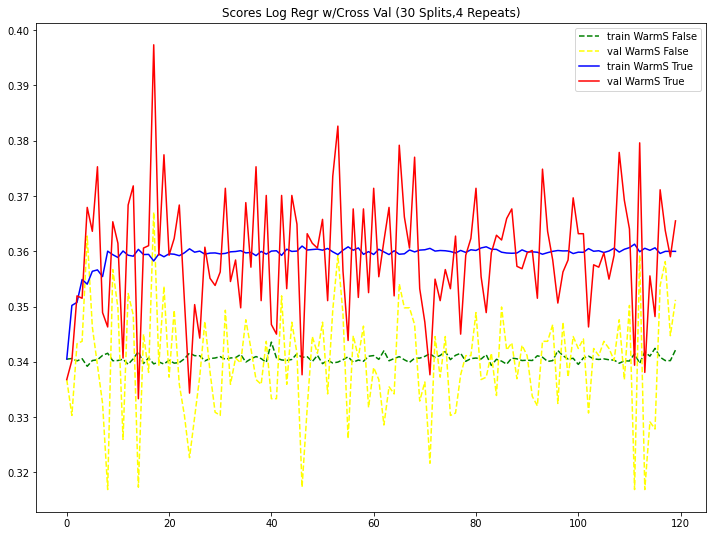

In [35]:
# Visualización general del entrenamiento
plt.figure(figsize = (12,9))
plt.plot(train_score, label="train WarmS False",color='green', linestyle='dashed')
plt.plot(val_score, label="val WarmS False", color="yellow",linestyle='dashed')
#plt.plot(train_scoreT, label="train WarmS True",color = 'b')
#plt.plot(val_scoreT, label="val WarmS True", color="red")
plt.legend()
#plt.title ("Scores Log Regr w/Cross Val (30 Splits,4 Repeats)")

In [33]:
model.score(X_test,y_test)

0.3465496368038741

### Knn

In [32]:
# Probar el modelo con diferentes valores de k
for k in range (57,58):
    model = KNeighborsClassifier(n_neighbors=k, p=1)
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    print("Accuracy: k=(", k, ") " ,metrics.accuracy_score(y_test, y_pred)*100, "%")

Accuracy: k=( 57 )  38.15577078288943 %


In [33]:
model.score(X_test, y_test)

0.38155770782889425

In [301]:
#USANDO VALIDACION CRUZADA
k_fold = RepeatedKFold(n_splits=8, n_repeats=4, random_state=1)
val_score = []
train_score = []
# define the model
model = KNeighborsClassifier(n_neighbors=57,p=1)

for i, (train, val) in enumerate(k_fold.split(X_train)):
    # train the model
    model.fit(X_train[train], y_train[train])
    score_val = model.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model.score(X_train[train], y_train[train])
    train_score.append(score_train)
    print(np.mean(val_score))
    if np.mean(val_score) >= 0.32 and len(val_score) > 20:
        #pickle.dump(model, open("model_saved.sav", "wb"))
        print ("Media del score de validacion:", np.mean(val_score))
        print ("Media del score de entrenamiento:", np.mean(train_score))
        print("STOP")
        break

0.29150973851285916
0.2894113849133757
0.29143799992826147
0.2928010330356182
0.29287190692784887
0.2932420145621298
0.2935063771580447
0.2937584588337798
0.29369990391260475
0.29305045586504386
0.293184301610582
0.29396838896246746
0.2939969141599968
0.29351401545777456
0.2934111869914692
0.2934422839732497
0.29341089320497116
0.2934846199613481
0.29378279247772543
0.2937444652933097
0.29395727727952703
0.29426325397266795
0.2938969072512525
0.2937449393300181
0.2936340097219524
0.2935398906896531
0.2936041915605637
0.2936946446198084
0.293869022884362
0.29374837802627085
0.2936285735165986
0.2936003344900292


In [302]:
model.score(X_test, y_test)

0.29681194511702985

In [48]:
print ("Media del score de validacion:", np.mean(val_score))

Media del score de validacion: 0.28372337253682534


### XGBoost

In [52]:
X_test.shape

(20000, 12)

In [110]:
model = XGBClassifier(n_estimators=42) 
model.fit(X_train, y_train) 
model.score(X_test, y_test)
#print("estim:", k, " - Score:", model1.score(X_test, y_test)*100, "%")


0.41491794457896153

In [61]:
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
k_fold = RepeatedKFold(n_splits=4, n_repeats=2, random_state=1)
val_score = []
train_score = []
# define the model
model = XGBClassifier(n_estimators=42) 

for i, (train, val) in enumerate(k_fold.split(X_train)):
    # train the model
    model.fit(X_train[train], y_train[train])
    score_val = model.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model.score(X_train[train], y_train[train])
    train_score.append(score_train)
    print(np.mean(val_score))
    if np.mean(val_score) >= 0.40 and len(val_score) > 20:
        #pickle.dump(model, open("model_saved.sav", "wb"))
        print ("Media del error de validacion:", np.mean(val_score))
        print ("Media del error de entrenamiento:", np.mean(train_score))
        print("STOP")
        break

0.4026864983281448
0.4011011184134671
0.40451208732080407
0.4028738614089704
0.4031015796148968
0.40289788231676854
0.403386536212548
0.40387553326415315


In [62]:
model.score(X_test,y_test)

0.41199219800914716

### SVC

In [43]:
from sklearn import svm
Clist = [1]#,10,100,1000]

In [44]:
for C in Clist:
    clf = svm.LinearSVC(C=C)
    clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print ('score: C = ', str(C), ": ", clf.score(X_test, y_test)*100, "%")

score: C =  1 :  33.039025963554266 %


In [ ]:
for C in Clist:
    clf = svm.LinearSVC(C=10)
    clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print ('score: C = ', str(C), ": ", clf.score(X_test, y_test)*100, "%")

### Decision Trees

In [260]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold

In [261]:
k_fold = RepeatedKFold(n_splits=5, n_repeats=4, random_state=1)
val_score = []
train_score = []
# define the model
model = RandomForestClassifier(n_estimators=50)

for i, (train, val) in enumerate(k_fold.split(X_train)):
    # train the model
    model.fit(X_train[train], y_train[train])
    score_val = model.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model.score(X_train[train], y_train[train])
    train_score.append(score_train)
    print(np.mean(val_score))
    if np.mean(val_score) >= 0.39 and len(val_score) > 10:
        #pickle.dump(model, open("model_saved.sav", "wb"))
        print ("Media del score de validacion:", np.mean(val_score))
        print ("Media del score de entrenamiento:", np.mean(train_score))
        print("STOP")
        break
        

0.36708701134930644
0.36590052692441677
0.36132233879792025
0.3626747101486325
0.36254029778660257
0.362394342312711
0.36165378152489985
0.3621072517846626
0.361451060024968
0.36151252442413584
0.3619390483415565
0.36222809889303753
0.362070093876014
0.36173648601576475
0.3615650631361212
0.3617643778376546
0.3616448640780623
0.3617523183122021
0.36172235021799953
0.3615661147929814


In [262]:
model.score(X_test,y_test)

0.36460855528652136

## `GRID SEARCH`

In [55]:
import pickle
# Load libraries
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier 
# Set random seed
np.random.seed(0)

In [56]:
to_test = np.arange(1, 5)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

In [61]:
# Create a pipeline

verbose = False # True si queremos que muestre más información durante el entrenamiento
number_of_processors = -1  # -1 all, -2 all but one, ...

logistic_params = {
    'classifier': [LogisticRegression(verbose=verbose, n_jobs=number_of_processors,warm_start=True)],
    'classifier__penalty': ['l1', 'l2'],#,'elasticnet','none'],
    'classifier__solver':['liblinear','newton-cg'],#'lbfgs','sag','saga']
    'classifier__C': np.logspace(-1, 0, 10)
    }

random_forest_params = {
    'classifier': [RandomForestClassifier(verbose=verbose, n_jobs=number_of_processors, warm_start=True)],
    'classifier__n_estimators': [10, 42,100,1000],
    'classifier__max_features': [1, 5]
    }

svm_params = {
    'classifier': [svm.SVC(verbose=verbose)],
    'classifier__kernel':('linear', 'rbf', 'sigmoid'), 
    'classifier__C':[0.2 , 0.5, 0.9], 
    'classifier__degree': to_test,
    'classifier__coef0': [-10.,-1., 0., 0.5, 10],
    'classifier__gamma': ('scale', 'auto')
    }
knn_params = {
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [5,14,57,81],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__leaf_size': [10,30,50],
    'classifier__p':[1,2]
    }
xgb_params = {
    'classifier': [XGBClassifier(n_jobs=number_of_processors)],
    'classifier__n_estimators': [42,80]
    }

# Create space of candidate learning algorithms and their hyperparameters
search_space = [
    #logistic_params,
    #random_forest_params,
    #svm_params,
    knn_params,
    #xgb_params
    ]


# Le podemos poner cualquier clasificador. Irá cambiando según va probando pero necesita 1.
pipe = Pipeline(steps=[('classifier', logistic_params['classifier'][0])])


In [62]:

def save_model(to_save, filepath):
    try:
        if file_exists(filepath=filepath):
            filepath = rename_filename(filepath=filepath)
        pickle.dump(to_save, open(filepath, 'wb'))
        print("Saved successfully")
        return True, filepath
    except Exception as e:
        print("Error during saving model:\n", e)
        return False, filepath

In [63]:
# save the model to disk
pipeline_filename = 'best_models_pipeline.sav'
model_filename = 'best_model.sav'

In [64]:
%%time

cv = RepeatedKFold(n_splits=4, n_repeats=1, random_state=1)
# Create grid search 
clf = GridSearchCV(estimator=pipe, param_grid=search_space, cv=cv, verbose=10, n_jobs=-1)

# Fit grid search
best_models_pipeline = clf.fit(X_train, y_train)
# View best model
separator = "\n############################\n"
print(separator)
print("best estimator:", best_models_pipeline.best_estimator_.get_params()['classifier'])
print(separator)
print("clf.best_params_", clf.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf.best_score_)

# Esta variable representa la clase del mejor modelo que ha encontrado y parcialmente entrenado*. 
best_model = best_models_pipeline.best_estimator_.get_params()['classifier']

#SAVE MODEL
success, pipeline_filename = save_model(to_save=best_models_pipeline, filepath=pipeline_filename)
success, model_filename = save_model(to_save=best_model, filepath=model_filename)

print("End GridSearch")



Fitting 4 folds for each of 96 candidates, totalling 384 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3

__________________


In [67]:
with open(file= model_filename, mode = 'rb') as model_save:
    bmodel = pickle.load(model_save)

In [68]:
type(bmodel)

sklearn.neighbors._classification.KNeighborsClassifier

In [69]:
bmodel

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=57, p=1)

In [70]:
bmodel.score(X_test,y_test)

0.29963680387409203

In [71]:
model=bmodel

## Una vez listo el modelo, toca predecir con el dataset de predicción 

In [72]:
solution = pd.read_csv("solution.csv")

In [73]:
solution

,id,days
0,314114,71-80
1,208989,41-50
2,305872,11-20
3,266099,11-20
4,13228,21-30
...,...,...
133739,318155,31-40
133740,144850,11-20
133741,180676,51-60
133742,39933,21-30


In [74]:
to_pred = pd.read_csv("test_set.csv")

In [75]:
to_pred = limpiar_df(df=to_pred,include_rows=False, elim_outl=False)

In [76]:
Xt =prepare_df.transformar_df(df=to_pred, aplic_encod=True,aplic_norm=False)

In [77]:
Xt = Xt.loc[:,cols_modelo]

In [78]:
Xt = Xt.values

In [79]:
model

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=57, p=1)

In [80]:
predictions_submit = model.predict(Xt)

In [81]:
predictions_submit = le_target.inverse_transform(predictions_submit) 

In [82]:
submission = pd.DataFrame({"id": to_pred["0"], "days": predictions_submit})

In [83]:
submission

,id,days
0,314114,21-30
1,208989,21-30
2,305872,21-30
3,266099,11-20
4,13228,21-30
...,...,...
133739,318155,11-20
133740,144850,11-20
133741,180676,21-30
133742,39933,21-30


In [85]:
metrics.accuracy_score(solution["days"],submission["days"])

0.2536188539298959

In [30]:
sample = pd.read_csv("sample_submission.csv")

In [31]:
# IMPORTANTE: Guardar cada modelo con un nombre diferente y en un archivo ir poniendo los parámetros con los que se ejecutó cada modelo (incluyendo el valor de seed)
if submission.shape == sample.shape:
    if submission.columns.all() == sample.columns.all():
        if submission.id.all() == sample.id.all():
            print("you're ready to submit!")
            submission.to_csv("to_submit.csv", index = False)

you're ready to submit!
